# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [52]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

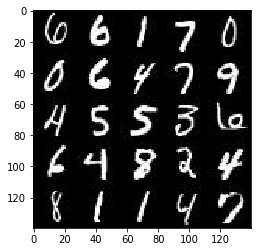

In [53]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

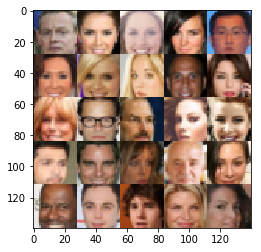

In [54]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [55]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [56]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    learning_rate= tf.placeholder(tf.float32, name="learning_rate")
    input_z= tf.placeholder(tf.float32,[None, z_dim], name="input_z")
    return inputs_real,input_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [57]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
        
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer shape 28x28x3 
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        # Second convolution layer
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # Third convolution layer
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [58]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
             
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256) 
        # Reshape and start deconv stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) # shape: 7x7x256
        # Second convolution layer
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')   
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2) # shape 14x14x128
        # Third convolution layer    
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # Dropout --> loss is not improving adding dropout
        drop = tf.nn.dropout(x3, keep_prob=0.5)
        # Output layer
        logits = tf.layers.conv2d_transpose(drop, out_channel_dim, 5, strides=1, padding='same')                                             
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [59]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
      
    smooth = 0.1 # label smoothing
    
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    disc_model_real, disc_logits_real = discriminator(input_real, reuse=False)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)

    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, labels=tf.ones_like(disc_model_real)*(1 - smooth)))
    
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)))
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)))

    disc_loss = disc_loss_real + disc_loss_fake
        
    return disc_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [60]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [62]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10 
    show_every=100
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7699... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 0.7341... Generator Loss: 1.6831
Epoch 1/2... Discriminator Loss: 3.4515... Generator Loss: 3.7194
Epoch 1/2... Discriminator Loss: 0.6448... Generator Loss: 2.5169
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 2.2863
Epoch 1/2... Discriminator Loss: 1.9184... Generator Loss: 2.4543
Epoch 1/2... Discriminator Loss: 1.6118... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 1.7128... Generator Loss: 2.0270
Epoch 1/2... Discriminator Loss: 1.4898... Generator Loss: 1.4151
Epoch 1/2... Discriminator Loss: 1.5973... Generator Loss: 1.6550


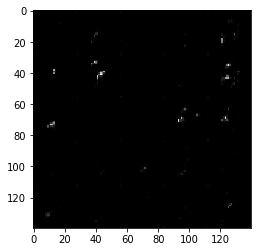

Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 1.2165
Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 0.6320
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.7122
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 2.2492
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.6718
Epoch 1/2... Discriminator Loss: 1.9542... Generator Loss: 0.2460
Epoch 1/2... Discriminator Loss: 1.6101... Generator Loss: 0.4054
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.5205
Epoch 1/2... Discriminator Loss: 1.8355... Generator Loss: 2.9649


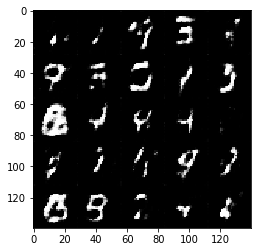

Epoch 1/2... Discriminator Loss: 1.6956... Generator Loss: 0.3243
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 1.7228
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.5317
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.9134
Epoch 1/2... Discriminator Loss: 1.4440... Generator Loss: 1.1147
Epoch 1/2... Discriminator Loss: 1.9133... Generator Loss: 0.3446
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 0.6521


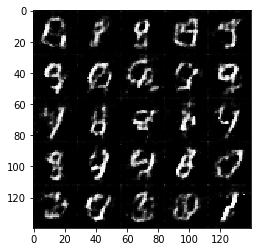

Epoch 1/2... Discriminator Loss: 1.9296... Generator Loss: 0.2490
Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 1.4522
Epoch 1/2... Discriminator Loss: 1.6052... Generator Loss: 2.0392
Epoch 1/2... Discriminator Loss: 1.4124... Generator Loss: 0.5544
Epoch 1/2... Discriminator Loss: 1.5607... Generator Loss: 0.4539
Epoch 1/2... Discriminator Loss: 1.8002... Generator Loss: 0.3715
Epoch 1/2... Discriminator Loss: 1.1719... Generator Loss: 1.1700
Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 1.6367


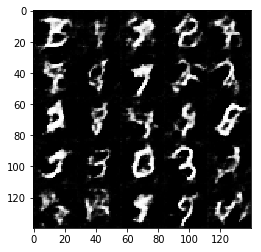

Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 0.8260
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 1.6140... Generator Loss: 2.2751
Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 1.4425
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 1.7781
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.8374


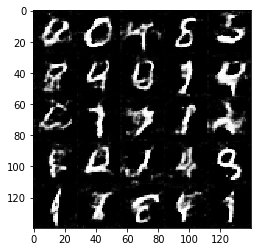

Epoch 1/2... Discriminator Loss: 1.6809... Generator Loss: 0.3738
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 1.2577
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 1.4417
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 1.5195... Generator Loss: 0.4486
Epoch 1/2... Discriminator Loss: 1.7379... Generator Loss: 0.3638
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.5467
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.6293
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 1.6911
Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 1.3798


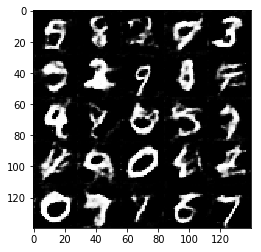

Epoch 1/2... Discriminator Loss: 1.2522... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.5766
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.5317... Generator Loss: 0.4606
Epoch 1/2... Discriminator Loss: 1.5644... Generator Loss: 0.4338
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.4721
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 1.0127
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 0.7671
Epoch 1/2... Discriminator Loss: 1.5327... Generator Loss: 0.4282
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 1.0411


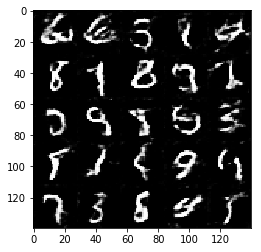

Epoch 1/2... Discriminator Loss: 1.4429... Generator Loss: 1.2593
Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 0.4566
Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 1.2243
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.4894
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 1.5016
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 1.3160


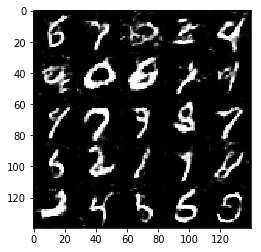

Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.8686
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 1.1349
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 0.5006
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 0.9384
Epoch 1/2... Discriminator Loss: 1.2310... Generator Loss: 0.6717
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 1.5010... Generator Loss: 0.5398
Epoch 2/2... Discriminator Loss: 1.5725... Generator Loss: 0.4916
Epoch 2/2... Discriminator Loss: 1.3296... Generator Loss: 1.9947
Epoch 2/2... Discriminator Loss: 1.5933... Generator Loss: 0.4523


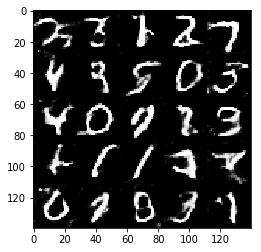

Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 0.9164
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.5668
Epoch 2/2... Discriminator Loss: 1.8631... Generator Loss: 0.3175
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.6898
Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 1.0013
Epoch 2/2... Discriminator Loss: 1.1613... Generator Loss: 1.0765
Epoch 2/2... Discriminator Loss: 1.5003... Generator Loss: 2.3990


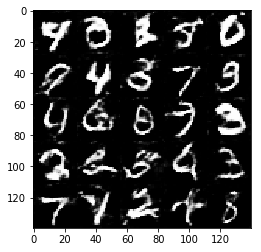

Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 2.2859
Epoch 2/2... Discriminator Loss: 1.5919... Generator Loss: 0.4847
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 0.4904
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 1.2076... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 1.5888
Epoch 2/2... Discriminator Loss: 1.0756... Generator Loss: 1.4243
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 1.5166
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 1.0038


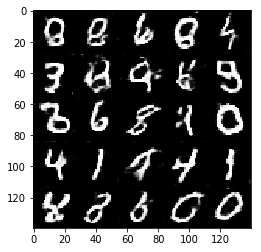

Epoch 2/2... Discriminator Loss: 1.2292... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 0.6166
Epoch 2/2... Discriminator Loss: 1.1298... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.0607... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.5169
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 1.3883
Epoch 2/2... Discriminator Loss: 1.8132... Generator Loss: 2.7983
Epoch 2/2... Discriminator Loss: 1.0673... Generator Loss: 1.0240
Epoch 2/2... Discriminator Loss: 1.4197... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.3838... Generator Loss: 0.5739


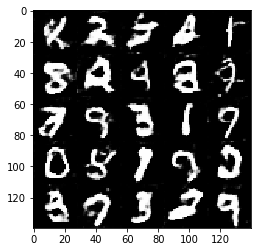

Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.4757
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 2.2919
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.9169
Epoch 2/2... Discriminator Loss: 1.2022... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 1.3998... Generator Loss: 0.5584
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 1.5794... Generator Loss: 0.4426
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.7877
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 1.2775


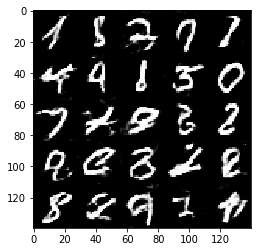

Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 1.4139
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 2.1675
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 1.1335
Epoch 2/2... Discriminator Loss: 1.5171... Generator Loss: 0.4515
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 1.0889
Epoch 2/2... Discriminator Loss: 1.4811... Generator Loss: 0.5244
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 1.9512
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 1.2394
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 2.0225
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 1.1163


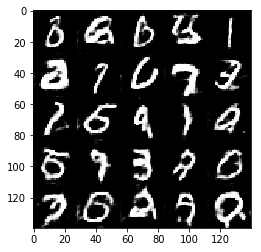

Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 1.6125
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 0.8028... Generator Loss: 1.4490
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 1.0703
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 1.7667
Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 0.9759
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 1.0774
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.8710


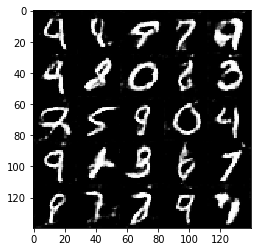

Epoch 2/2... Discriminator Loss: 1.2556... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 1.4692... Generator Loss: 0.4887
Epoch 2/2... Discriminator Loss: 0.8648... Generator Loss: 1.2699
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 1.9262
Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 1.0931
Epoch 2/2... Discriminator Loss: 1.0265... Generator Loss: 0.9796
Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 0.9064
Epoch 2/2... Discriminator Loss: 1.1638... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 0.8972... Generator Loss: 1.1874


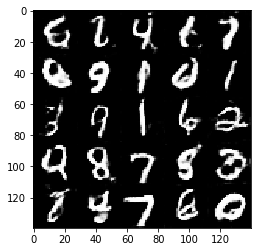

Epoch 2/2... Discriminator Loss: 0.9854... Generator Loss: 2.1085
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 0.9738
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 1.6262
Epoch 2/2... Discriminator Loss: 0.8260... Generator Loss: 1.5199
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 1.1517
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 1.0792
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 2.2098
Epoch 2/2... Discriminator Loss: 1.4977... Generator Loss: 0.4782


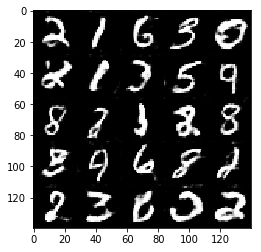

Epoch 2/2... Discriminator Loss: 1.0545... Generator Loss: 0.9141


In [63]:
batch_size = 70
z_dim = 100
learning_rate = 0.003
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.2987... Generator Loss: 0.1057
Epoch 1/1... Discriminator Loss: 2.4090... Generator Loss: 0.2639
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 1.4637
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 2.6820
Epoch 1/1... Discriminator Loss: 1.6016... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.7080
Epoch 1/1... Discriminator Loss: 1.8180... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 3.0632... Generator Loss: 0.1362
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.4745


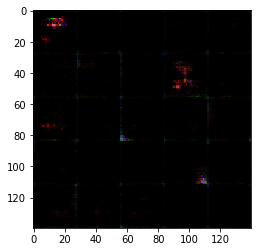

Epoch 1/1... Discriminator Loss: 0.4342... Generator Loss: 2.9493
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 1.2427
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 4.1972
Epoch 1/1... Discriminator Loss: 1.9870... Generator Loss: 4.5116
Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 3.5686
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 1.1202
Epoch 1/1... Discriminator Loss: 1.8959... Generator Loss: 0.3801
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.9782


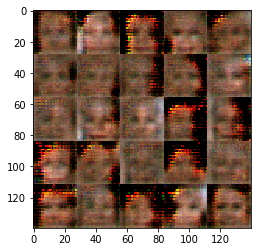

Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.6313... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 1.4076
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 1.1728
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 1.6875
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.6514... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8541


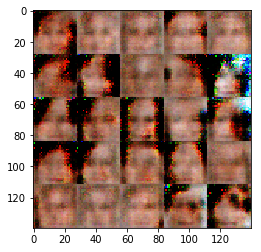

Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.4771
Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.5791


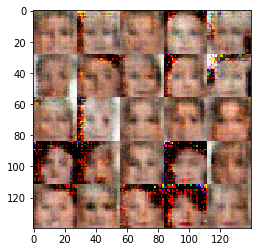

Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 1.6953... Generator Loss: 1.5761
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8697


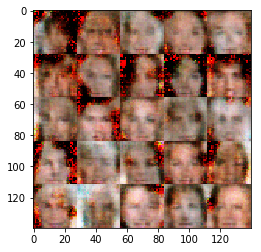

Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.6080... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.5284
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.5448


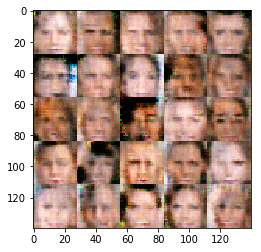

Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 1.0279


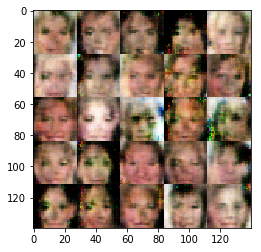

Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7250


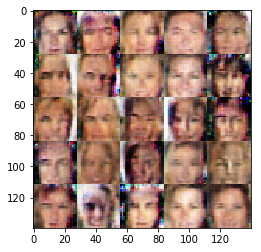

Epoch 1/1... Discriminator Loss: 1.7601... Generator Loss: 1.5240
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.9508


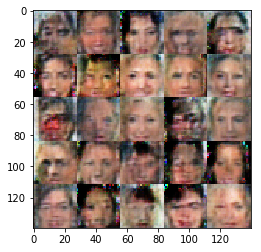

Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6201


In [ ]:
batch_size = 65
z_dim = 100
learning_rate = 0.003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.